## The problem . . . 

We want to calculate Pi on the Y chromosome. To do this, we need to use only loci that are polymorphic between Y chromosomes in a population, not between X and Y, or between X's. 

As there is no direct way of determining whether a SNP is on the Y or not, we have to filter our called SNPs on chr19 & chr12 to remove X vs Y SNPs and SNPs that are on the X. 

To filter X vs Y SNPs, we have simply removed loci that in all males ( 0.45 <= freq(M) >= 0.55 ) and never in females. 

To filter X SNPs, we have removed loci that are found in males and females. 

Thus we should be left with genes which are polymorphic in males (freq <= 0.45) and never found in females. 

However, doing this, gives us Pi estimates which are too high to be real. Thus, we must still be including either X vs Y variation, or variation on the X. 

The question addressed here is <b> How to remove this variation to get an unbiased Pi estimate for the Y </b>

### Question 1. Is the extra polymorphism on the Gw Y coming from X vs Y SNPs, or X-linked SNPs? 

To test this, we could compare M vs F frequencies. . . 

- Loci which are fixed between X and Y should form a distinctive cloud, at a freq of 0 in females and 0.5 in males. 
- Loci which are polymorphic on the X should have double the frequeny in females than males. . . 

We can compare the distribution of male and female allele frequencies on Chr19 and Chr12 before and after filtering. This should allow us to see how efficiently our filtering is working. 

Sample genotypes are in two VCF files:
1. Males - this VCF has been filtered for quality, depth, missingness, includes only males, and only genome regions with X vs Y shared genes. 
2. Females - this VCF has been filtered for quality, depth, missingness, includes only females, and only genome regions with X vs Y shared genes.


In [1]:
Male_VCF_path = "/Users/dj20y461/Data_temp/Stickleback/Y_comp/Pi_Y/Gw.XYshared.SNP.GQ20.meanDP12-54.non-ref-ac-1.max-miss-count-14.vcf.gz"
Female_VCF_path = "/Users/dj20y461/Data_temp/Stickleback/Y_comp/Pi_Y/Gw.auto.chr12_19_FemaleOnly.GQ20.meanDP12-56.non-ref-ac-1.max-miss-count-2.vcf.gz"

Define function to get allele frequencies using pysam

In [2]:
VCF_path = "/home/djeffrie/Data/Stickleback/Y_chrom_comp/Pi/Gw_Autos_X_filtered_RHB_only_MASK.recode.vcf.gz"

In [3]:
def get_freqs(VCF_path, chrom = None, start = None, stop = None, region = None, samples = []):
    
    """
    Get allele frequencies for each record in a VCF
    """
    
    from pysam import VariantFile
    
    freqs = {}

    VCF = VariantFile(VCF_path)
    
    for record in VCF.fetch(chrom, region = region):

        ID = "%s_%s" % (record.chrom, record.pos)

        freqs[ID] = {}

        N_genotypes = 0
        N_0 = 0
        N_1 = 0

        for sample in record.samples.values():

            ## Count alleles
            
            if sample.name in samples: 

                if sample.allele_indices[0] != None:

                    N_genotypes += 1    

                    if sample.allele_indices[0] == 0:
                        N_0 += 1

                    elif sample.allele_indices[0] == 1:
                        N_1 += 1

                    if sample.allele_indices[1] == 0:
                        N_0 += 1

                    elif sample.allele_indices[1] == 1:
                        N_1 += 1


        ## calculate frequencies

        if N_0 == 0:
            f_ref = 0
        else:
            f_ref = N_0/(N_genotypes*2)

        if N_1 == 0:
            f_alt = 0
        else:
            f_alt = N_1/(N_genotypes*2)

        freqs[ID]["N_genotypes"] = N_genotypes
        freqs[ID]["f_ref"] = f_ref
        freqs[ID]["f_alt"] = f_alt
    
    return freqs
    
    

## Autosomes

In [4]:
males = [ "Gw02_M", "Gw04_M", "Gw05_M", "Gw08_M", "Gw10a_M", "Gw11a_M", "Gw12_M", "Gw14_M", "Gw15_M", "Gw16_M", "Gw17_M", "Gw1a_M", "Gw2a_M", "Gw4a_M", "Gw5a_M", "Gw6a_M", "Gw7a_M", "Gw8a_M", "Gw9a_M"]

autosomes = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr20", "chr21"]

male_auto_freqs = {}

for chrom in autosomes:
    male_auto_freqs.update(get_freqs(VCF_path, 
                                     region = chrom, 
                                     samples = males))


In [7]:
females = ["Gw01_F", "Gw03_F", "Gw06_F", "Gw07_F"]

chromosomes = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr20", "chr21"]

female_auto_freqs = {}

for chrom in chromosomes:
    female_auto_freqs.update(get_freqs(VCF_path, 
                                       region = chrom, 
                                       samples = females))

In [8]:
len(female_auto_freqs)

4742769

N loci: 336504


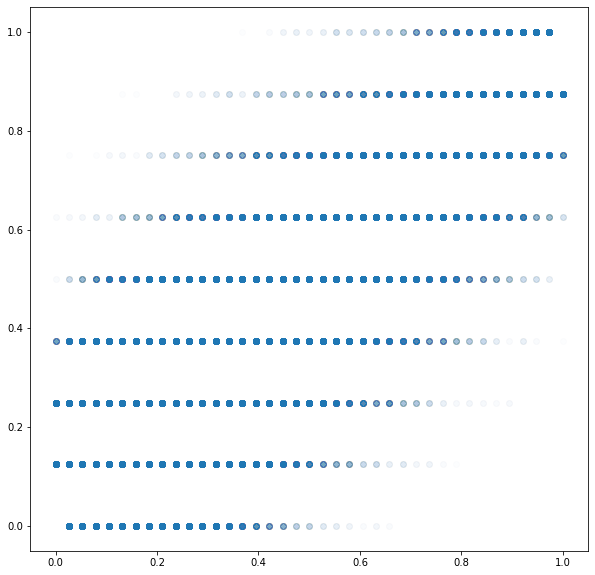

In [12]:
x = []
y = []

for locus in male_auto_freqs:
    
    if all([male_auto_freqs[locus]["N_genotypes"] >= 19, female_auto_freqs[locus]["N_genotypes"] == 4]):
        
        if not any([all([male_auto_freqs[locus]["f_alt"] == 0 , female_auto_freqs[locus]["f_alt"] == 0]),
                   all([male_auto_freqs[locus]["f_alt"] == 1 , female_auto_freqs[locus]["f_alt"] == 1])]):
               
            x.append(male_auto_freqs[locus]["f_alt"])
            y.append(female_auto_freqs[locus]["f_alt"])

print("N loci: %s" % len(x))
           
from matplotlib import pyplot as plt

plt.figure(figsize = (10,10))
plt.scatter(x, y, alpha=0.01)

plt.show()    

## Sex chromosomes

In [34]:
males = [ "Gw02_M", "Gw04_M", "Gw05_M", "Gw08_M", "Gw10a_M", "Gw11a_M", "Gw12_M", "Gw14_M", "Gw15_M", "Gw16_M", "Gw17_M", "Gw1a_M", "Gw2a_M", "Gw4a_M", "Gw5a_M", "Gw6a_M", "Gw7a_M", "Gw8a_M", "Gw9a_M"]

chromosomes = ["chr12", "chr19"]

male_freqs = {}

for chrom in chromosomes:
    male_freqs.update(get_freqs(VCF_path, 
                  region = chrom, 
                  samples = males))


In [35]:
len(male_freqs)

267424

In [36]:
females = ["Gw01_F", "Gw03_F", "Gw06_F", "Gw07_F"]

chromosomes = ["chr12", "chr19"]

female_freqs = {}

for chrom in chromosomes:
    female_freqs.update(get_freqs(VCF_path, 
                  region = chrom, 
                  samples = females))

In [37]:
len(female_freqs)

267424

N loci: 16807


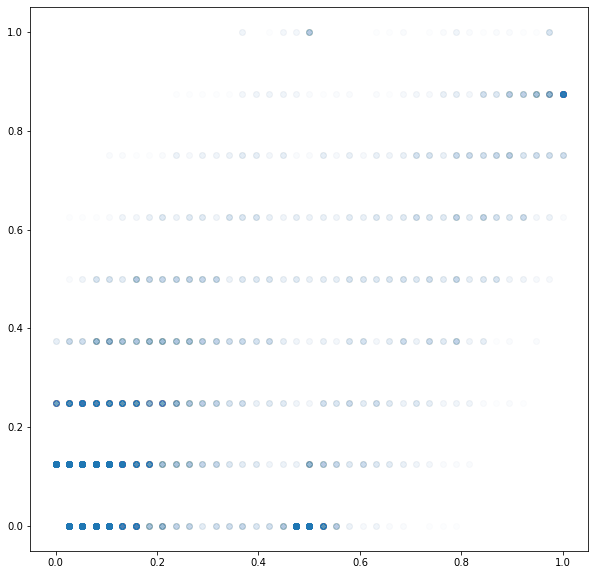

In [38]:
x = []
y = []

for locus in male_freqs:
    
    if all([male_freqs[locus]["N_genotypes"] >= 19, female_freqs[locus]["N_genotypes"] == 4]):
        
        if not any([all([male_freqs[locus]["f_alt"] == 0 , female_freqs[locus]["f_alt"] == 0]),  ## filter loci that are fixed for the same allele in both sexes (not sure why these are in there, but they are)
                   all([male_freqs[locus]["f_alt"] == 1 , female_freqs[locus]["f_alt"] == 1])]):
    
            x.append(male_freqs[locus]["f_alt"])
            y.append(female_freqs[locus]["f_alt"])

print("N loci: %s" % len(x))
           
from matplotlib import pyplot as plt

plt.figure(figsize = (10,10))
plt.scatter(x, y, alpha=0.01)

plt.show()    

### Next steps

Filter the loci based on their frequencies and plot. 

Loci that are polymorphic between Y chromosomes in a population should be < 0.5 frequency in males and never found in females. I.e. the bottom left of the plot below. 

The choice of cut-offs here is important. How do I determine the difference between a locus that is polymorphic among Ys and present in most, vs a locus that is fixed between Ys but where a couple of gentypes were missed? 

- First, the freq plot above shows us that there is an enrichment of loci between a freq of 0.4 - 0.6 in males. So this is likely our sex linked set. So I will set my cut-off at <= 0.4. 


N loci: 6902


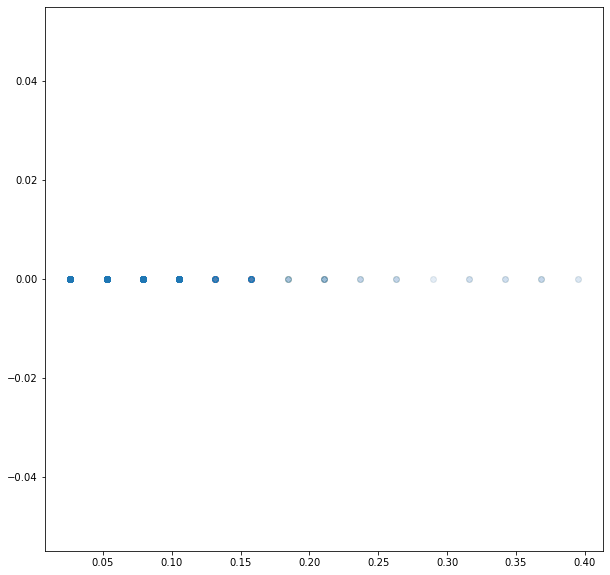

In [39]:
x = []
y = []

keep = []

for locus in male_freqs:
    
    if all([male_freqs[locus]["N_genotypes"] >= 19, female_freqs[locus]["N_genotypes"] == 4]):
        
        if not any([all([male_freqs[locus]["f_alt"] == 0 , female_freqs[locus]["f_alt"] == 0]),  ## filter loci that are fixed for the same allele in both sexes (not sure why these are in there, but they are)
                   all([male_freqs[locus]["f_alt"] == 1 , female_freqs[locus]["f_alt"] == 1])]):
    
            ## additional filters

            if all([male_freqs[locus]["f_alt"] <= 0.4, female_freqs[locus]["f_alt"] == 0]):
                
                keep.append(locus)
                
                x.append(male_freqs[locus]["f_alt"])
                y.append(female_freqs[locus]["f_alt"])

print("N loci: %s" % len(x))
           
from matplotlib import pyplot as plt

plt.figure(figsize = (10,10))
plt.scatter(x, y, alpha=0.01)

plt.show()    

6000+ loci seems high to me. So I suspect we have alleles in here that are in fact not on the Y. 

In [45]:
with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/Pi/Kept_loci_1.txt", 'w') as keep_out:

    for locus in keep:
        keep_out.write("%s\t%s\n" % (locus.split("_")[0], locus.split("_")[1]))

    

I used these loci to calculate Pi . . . using only males 

## First what is Pi on autosomes?

In [5]:
auto_pi = {}
all_pi = []

with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/Pi/Gw_Autos_X_filtered_RHB_only_MASK_Pi.windowed.pi", 'r') as unfiltered_pi:
    
    header = next(unfiltered_pi)
    
    for locus in unfiltered_pi:
        if not any([locus.split()[0] == "chr12", locus.split()[0] == "chr19"]):
            chrom = locus.split()[0]
            
            if chrom not in auto_pi:
                auto_pi[chrom] = {}
                auto_pi[chrom]["POS"] = []
                auto_pi[chrom]["PI"] = []
                
            
            auto_pi[chrom]["POS"].append(int(locus.split()[1]))
            auto_pi[chrom]["PI"].append(float(locus.split()[4]))
            all_pi.append(float(locus.split()[4]))

In [6]:
chroms = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr20", "chr21"]

### Add position of centromere seq blasts


In [13]:
cent_hits = {}

with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/centromeres/Gw_cent.out") as cent_positions:
    
    for line in cent_positions:
        
        chrom = line.split()[1]
        pos = int(line.split()[8])
        
        if chrom not in cent_hits:
            cent_hits[chrom] = []
            
        cent_hits[chrom].append(pos)
    

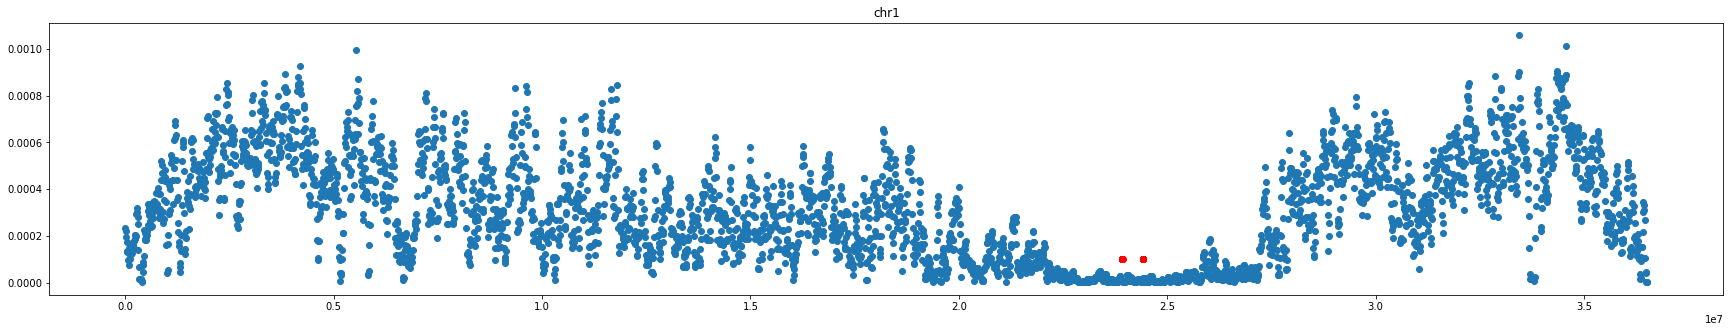

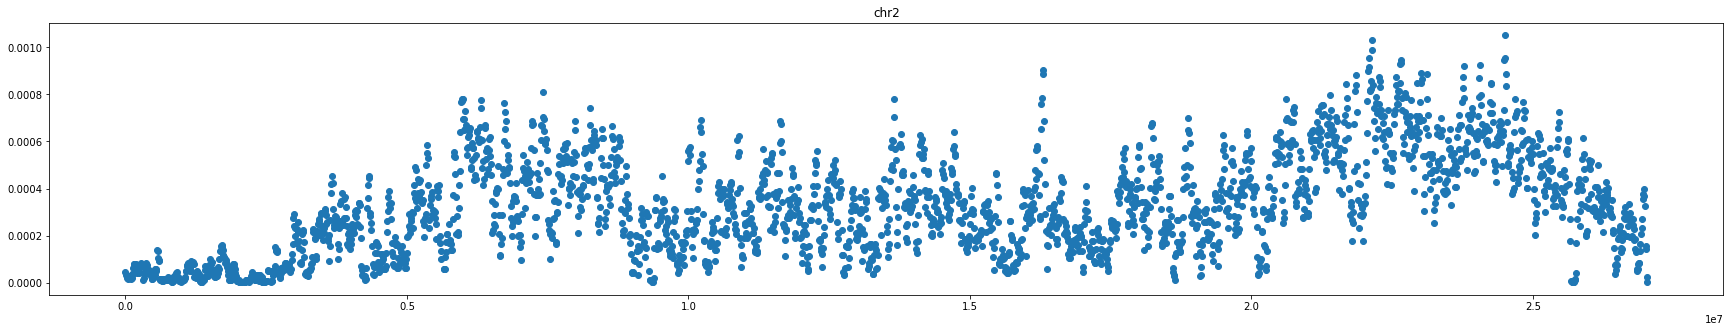

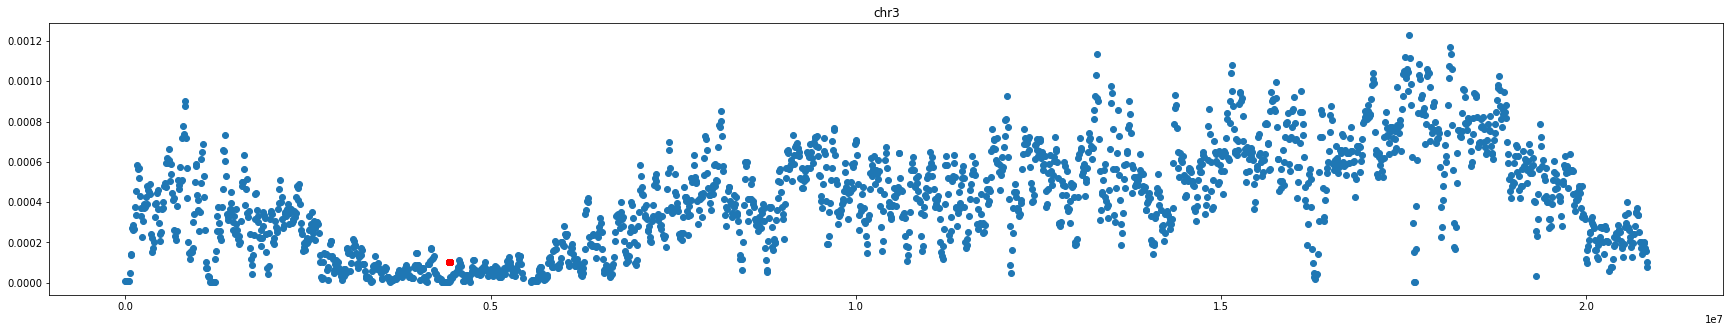

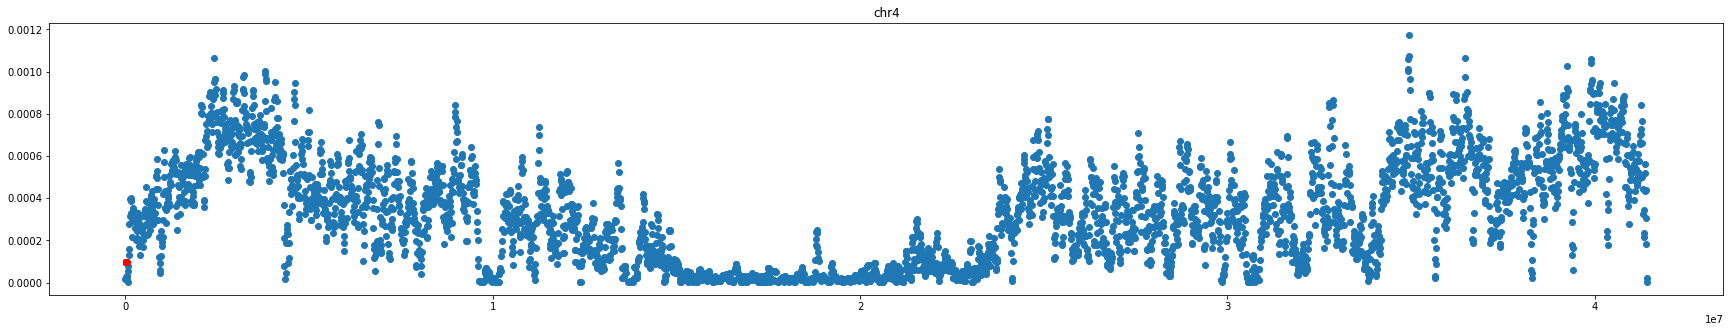

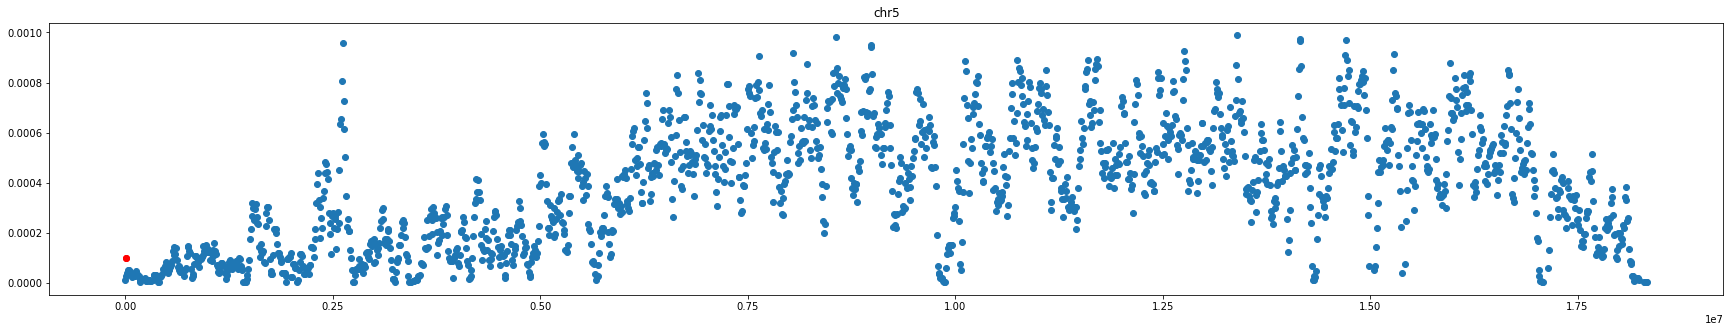

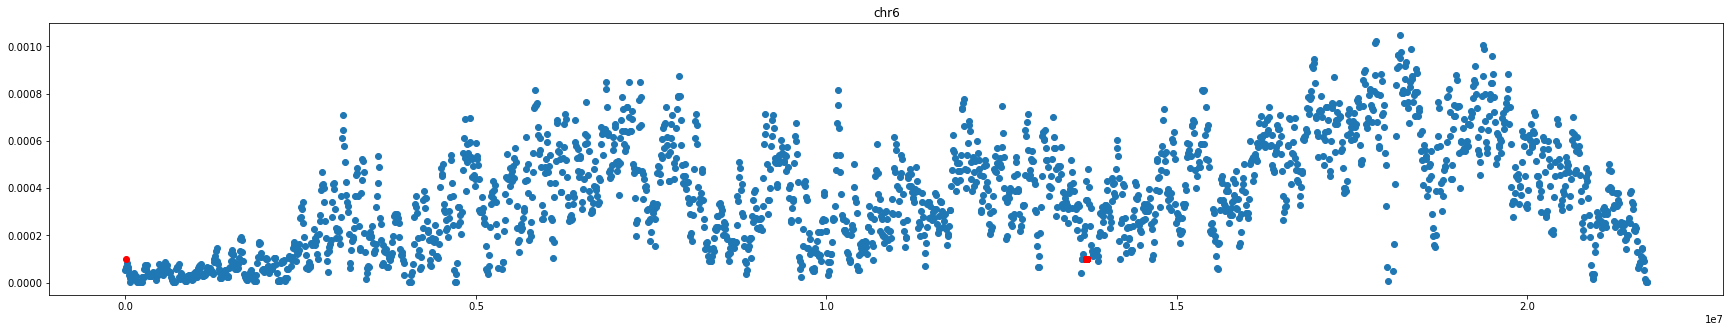

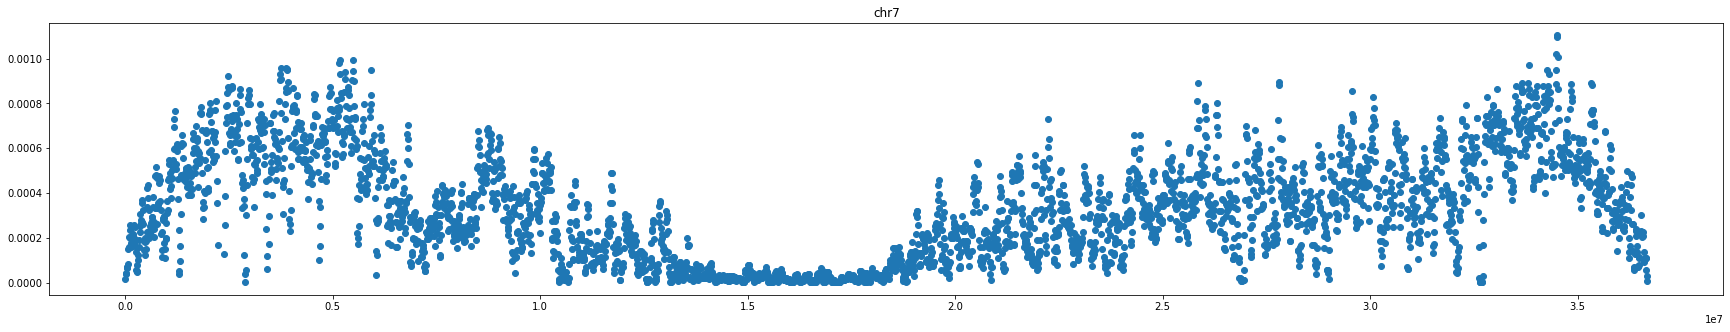

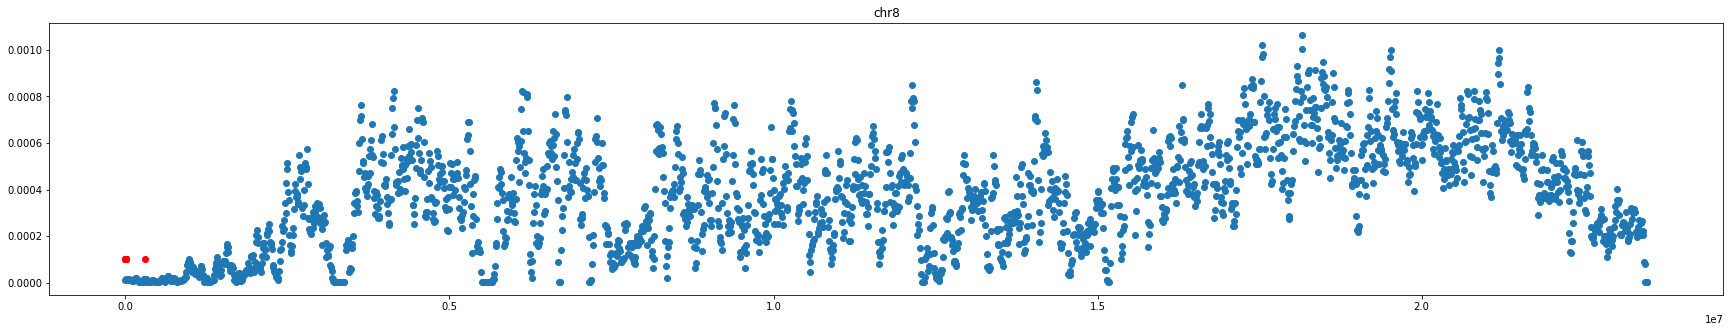

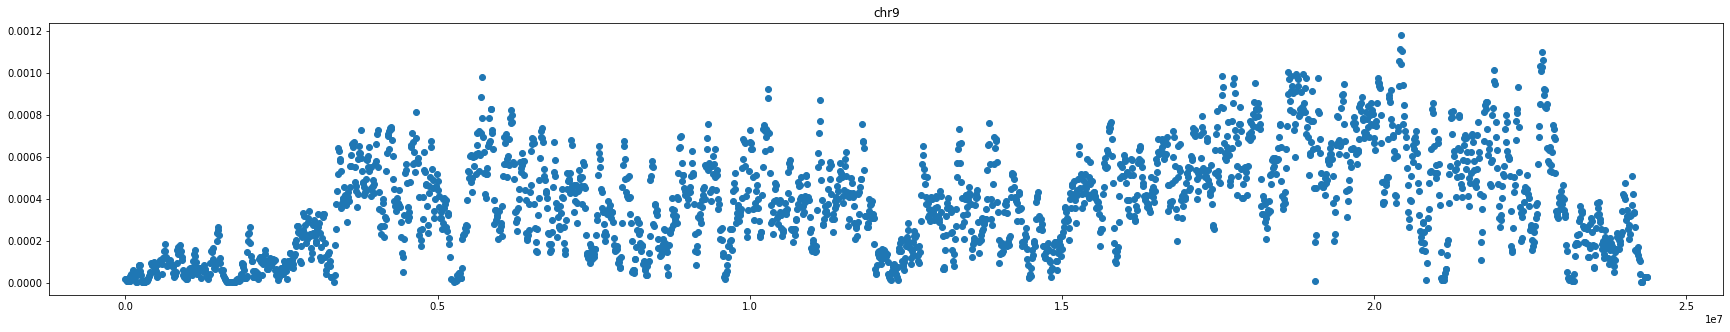

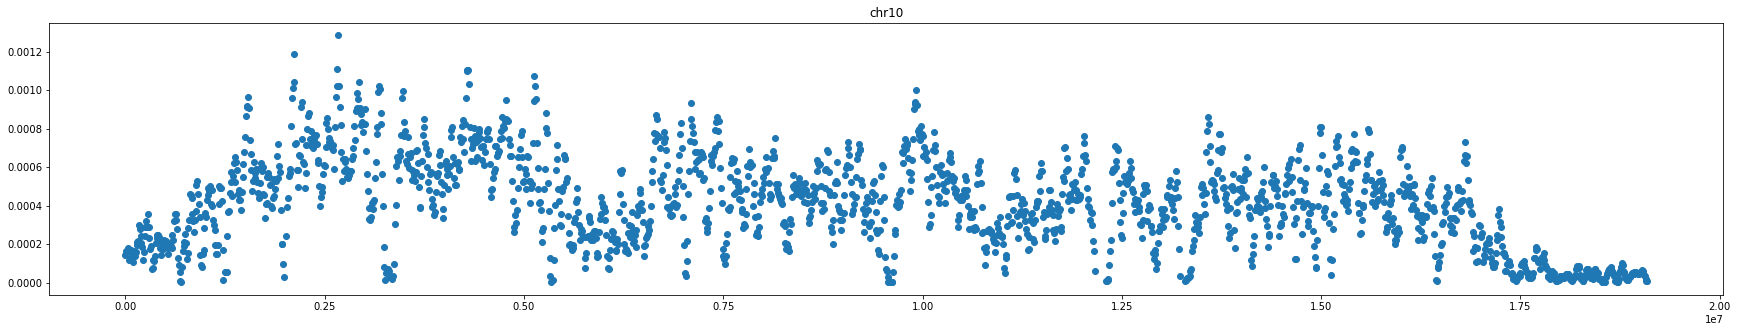

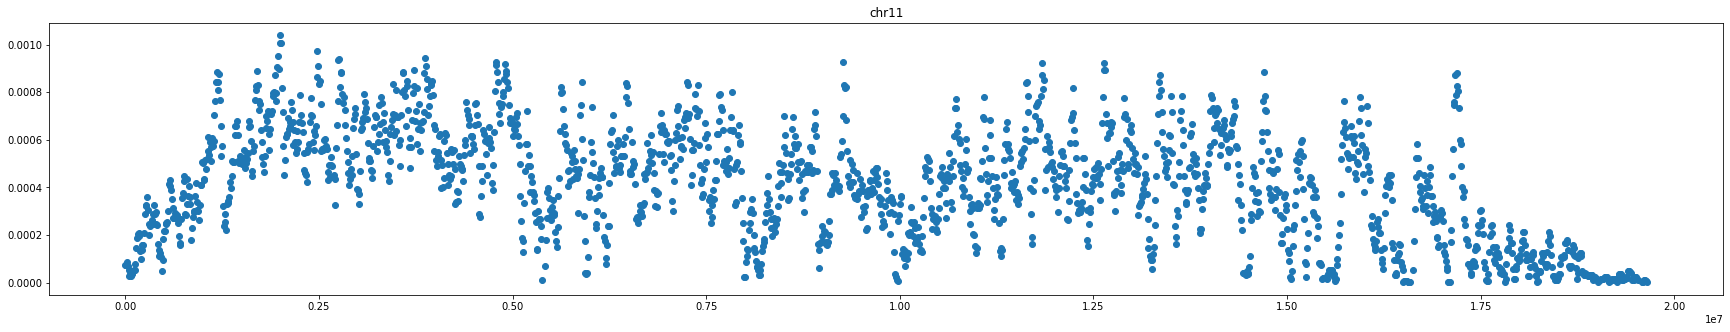

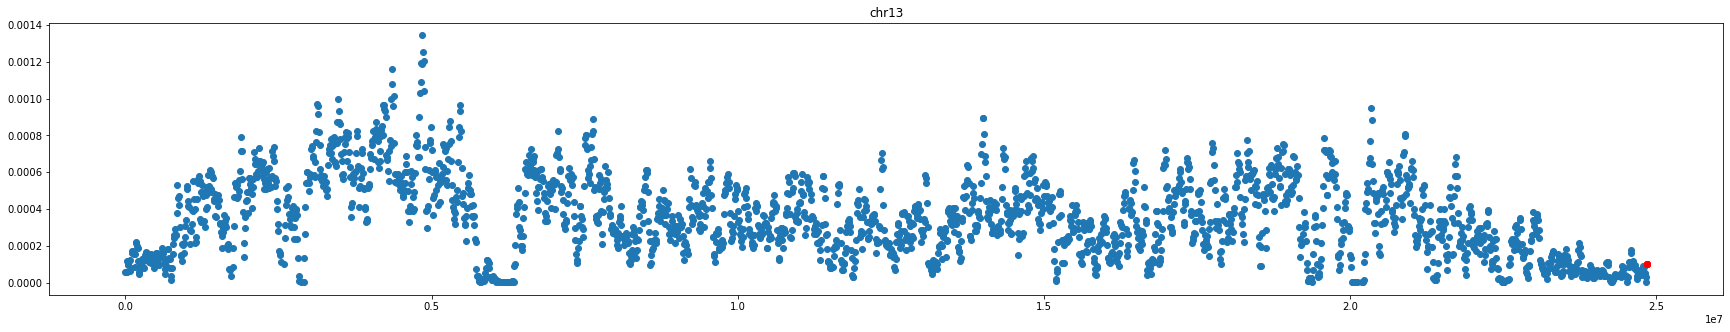

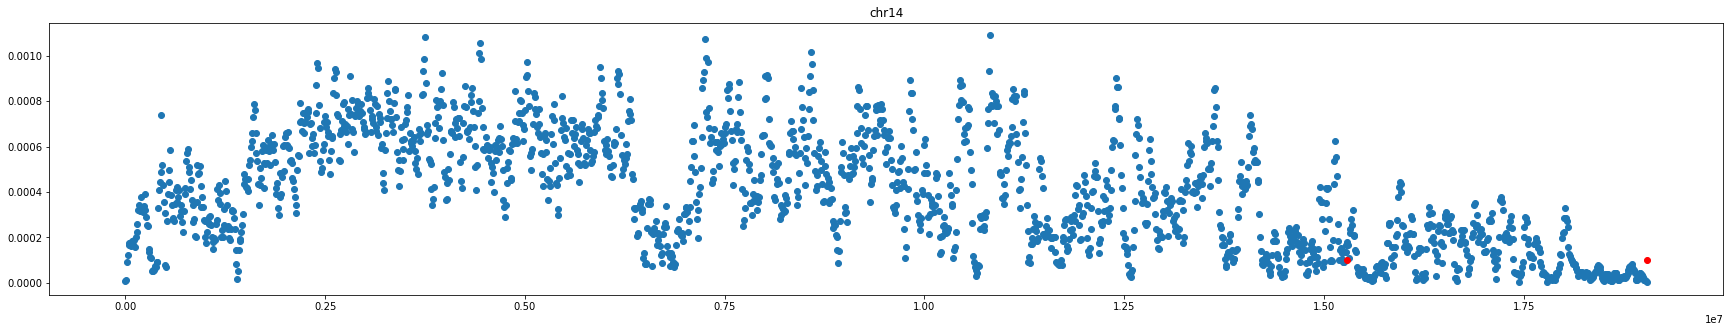

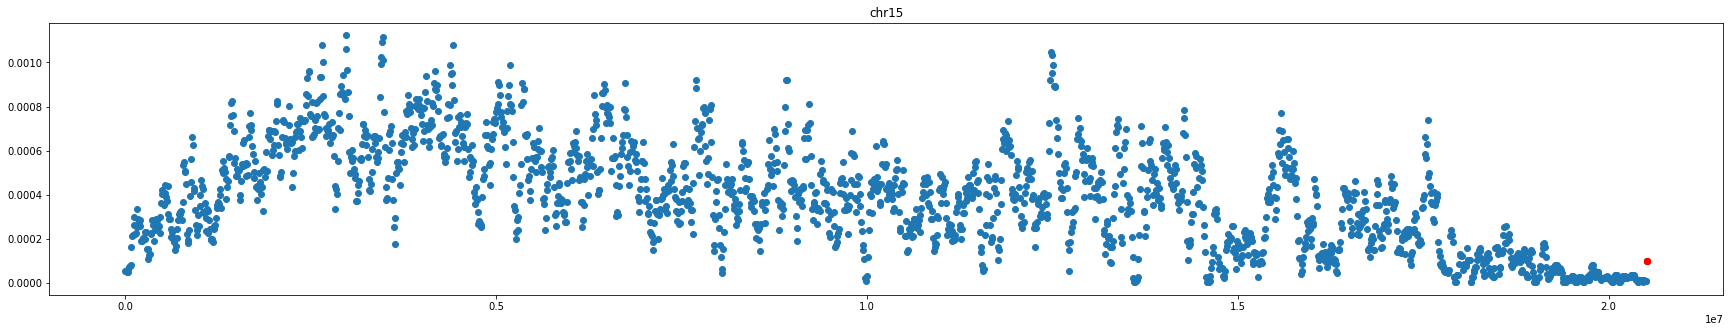

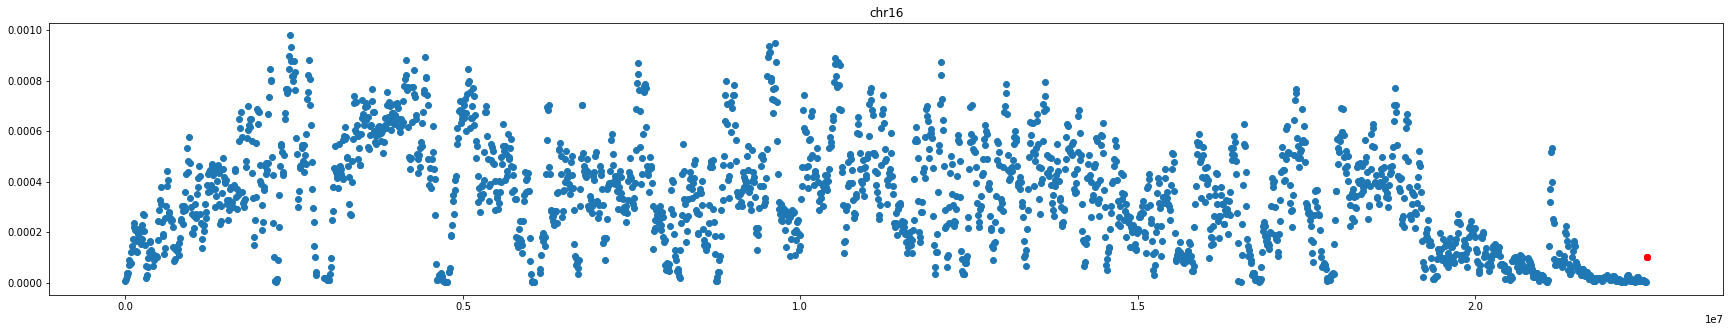

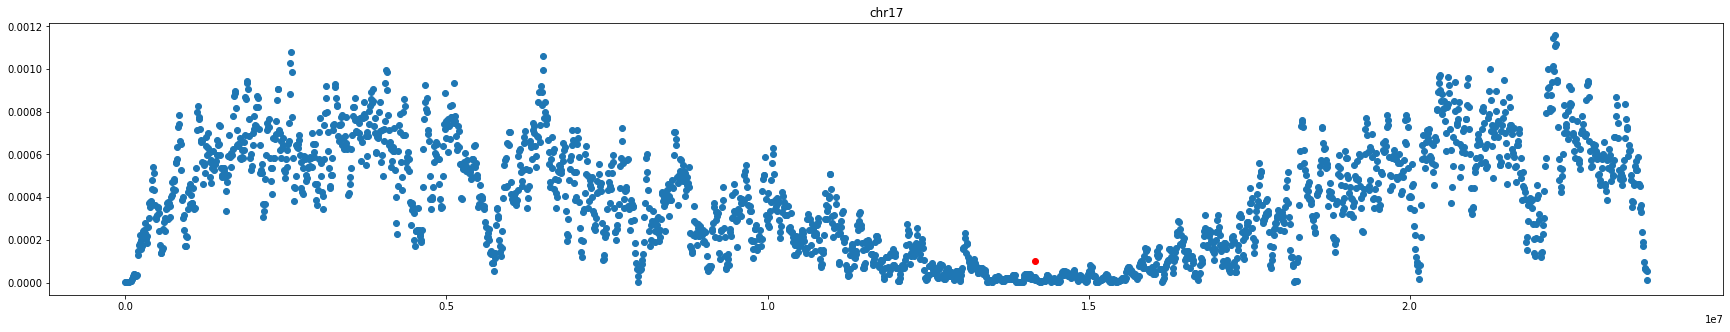

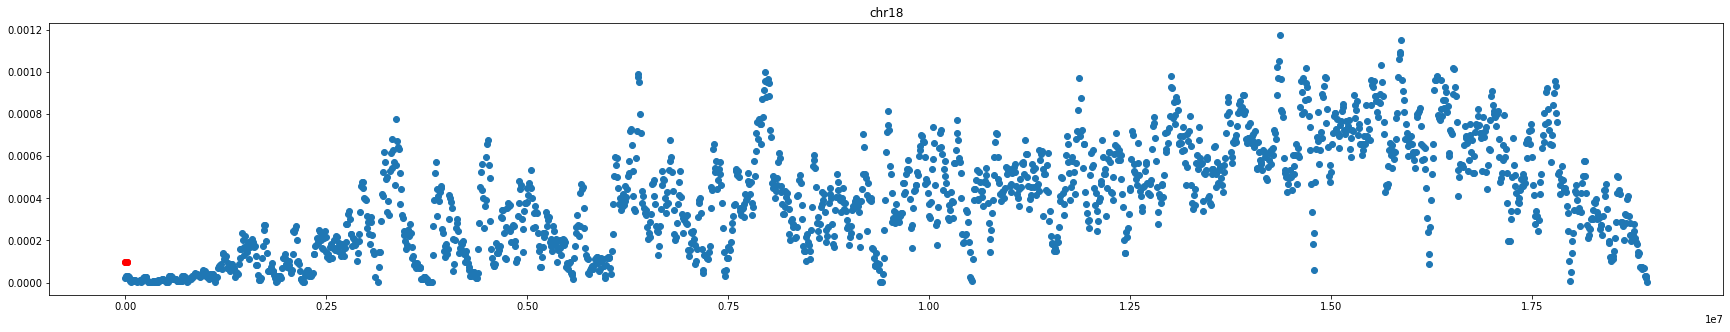

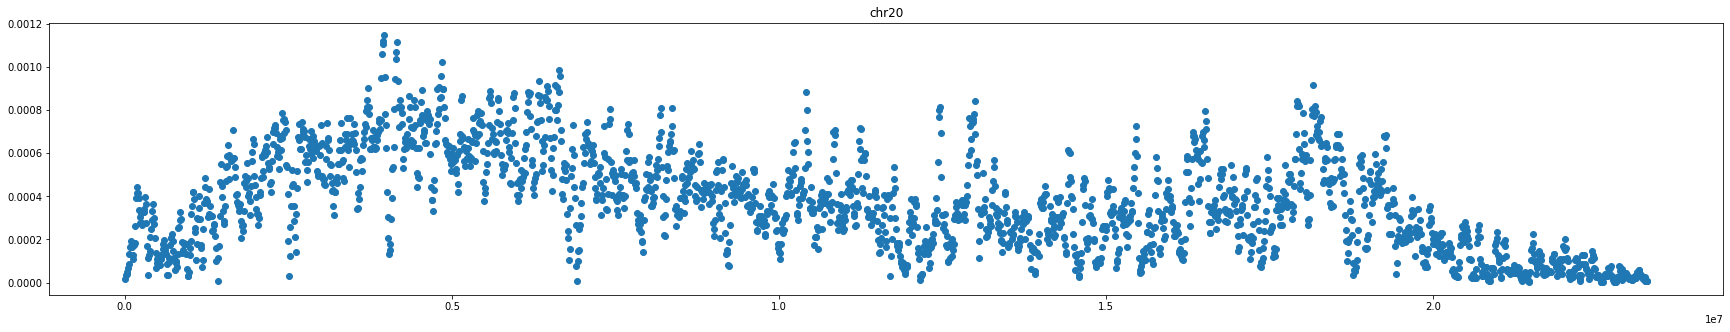

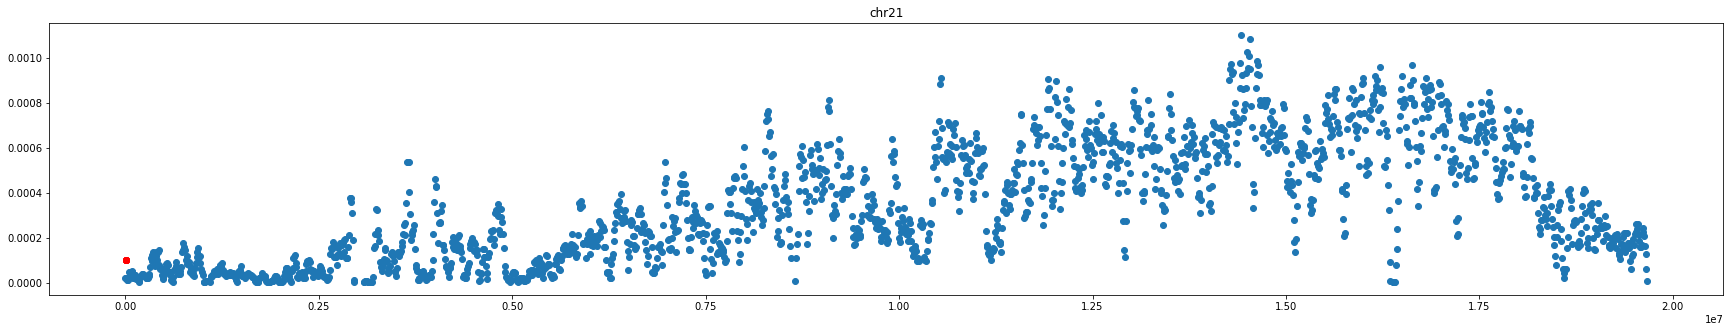

In [14]:
from matplotlib import pyplot as plt
for chrom in chroms:
    plt.figure(figsize = (30,5))
    plt.scatter(auto_pi[chrom]["POS"] , auto_pi[chrom]["PI"])
    
    if chrom in cent_hits:
        plt.scatter(cent_hits[chrom], [0.0001]*len(cent_hits[chrom]), c = "red")
    plt.title(chrom)
    plt.show()
    

### First, without filtering loci

In [77]:
x12 = []
y12 = []

x19 = []
y19 = []

with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/Pi/Gw_Autos_X_filtered_RHB_only_MASK_Pi.windowed.pi", 'r') as unfiltered_pi:
    
    for locus in unfiltered_pi:
        if locus.split()[0] == "chr12":
            x12.append(int(locus.split()[1]))
            y12.append(float(locus.split()[4]))
            
        elif locus.split()[0] == "chr19":
            x19.append(int(locus.split()[1]))
            y19.append(float(locus.split()[4]))

            


<function matplotlib.pyplot.show(close=None, block=None)>

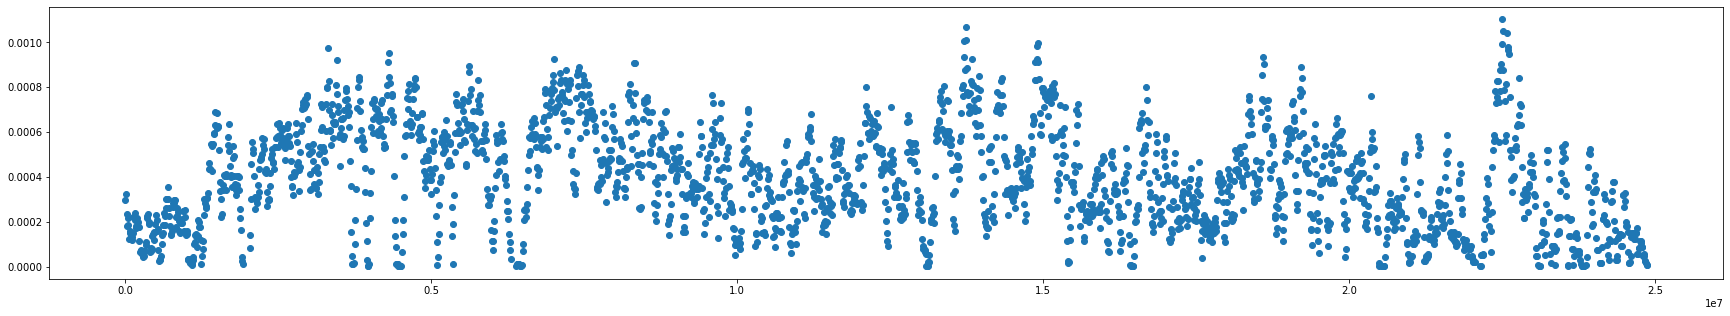

In [78]:
plt.figure(figsize = (30,5))
plt.scatter(x12, y12)
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

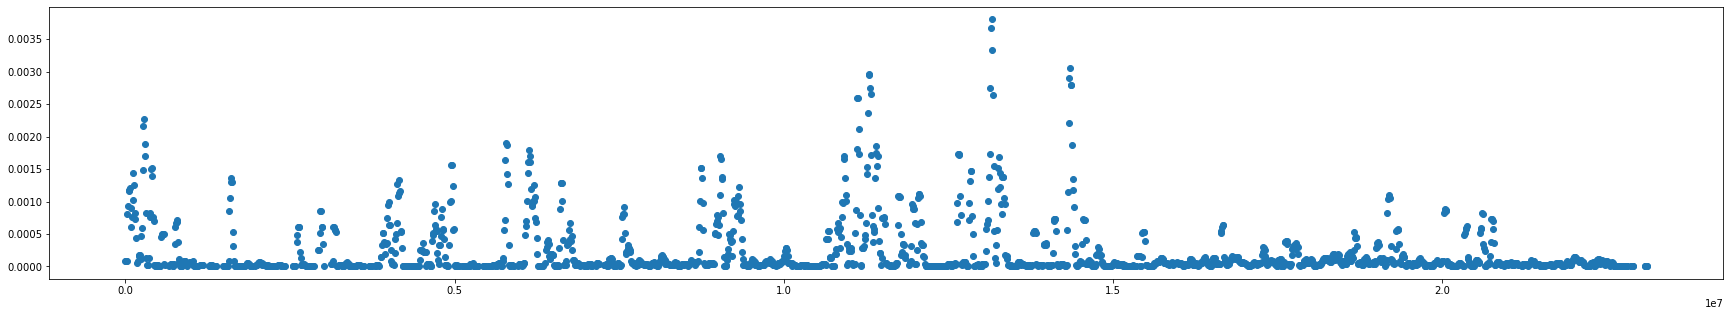

In [79]:
plt.figure(figsize = (30,5))
plt.scatter(x19, y19)
plt.show

Note, this will be mostly X vs Y divergence, so this doesn't make much sense. 

## Now after filtering


In [80]:
x12 = []
y12 = []

x19 = []
y19 = []

with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/Pi/Gw_Autos_X_filtered_RHB_only_MASK_Pi_kept_1_males.windowed.pi", 'r') as unfiltered_pi:
    
    for locus in unfiltered_pi:
        if locus.split()[0] == "chr12":
            x12.append(int(locus.split()[1]))
            y12.append(float(locus.split()[4]))
            
        elif locus.split()[0] == "chr19":
            x19.append(int(locus.split()[1]))
            y19.append(float(locus.split()[4]))

            


<function matplotlib.pyplot.show(close=None, block=None)>

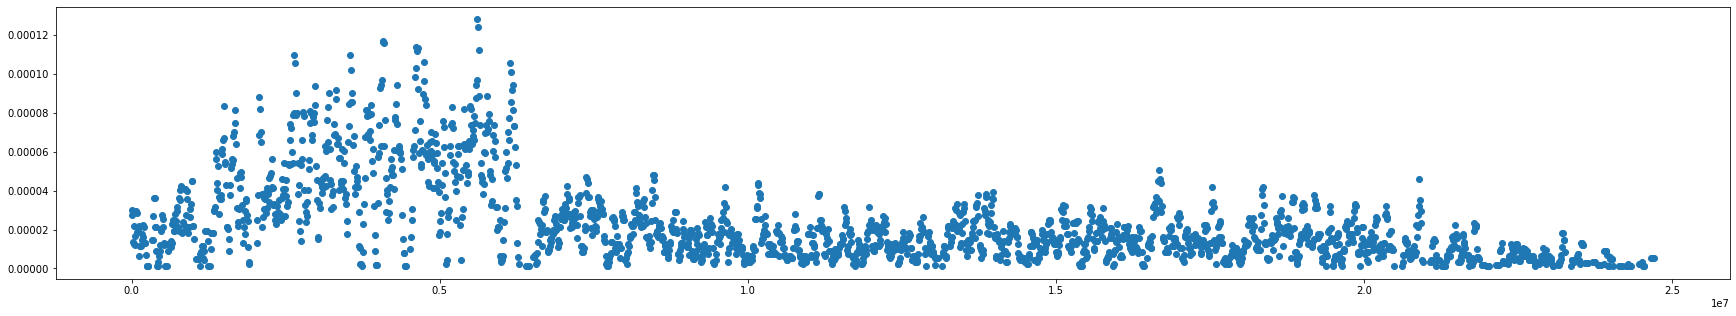

In [81]:
plt.figure(figsize = (30,5))
plt.scatter(x12, y12)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

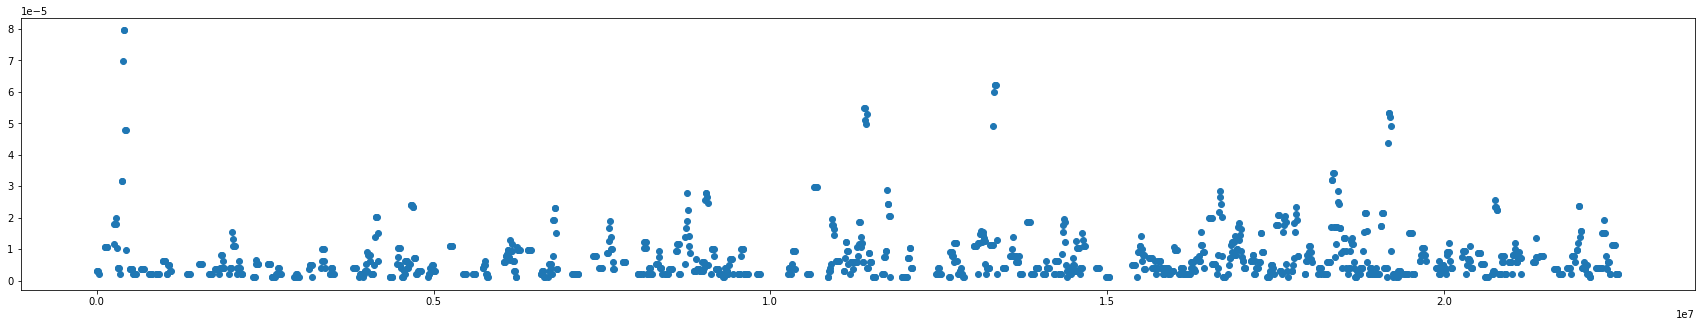

In [82]:
plt.figure(figsize = (30,5))
plt.scatter(x19, y19)
plt.show

Ok its starting to make more sense, at lease on Chr12. The PAR region clearly has higher Pi, which is as expected. In contrast, the rest of Chr12 has much lower Pi, though it doesn't seem to differ much between strata at all. Then again, neither does Fst in this region. 

On Chr19 the image is similar, Pi doesn't seem to change much along the genome. There are still some clear peaks though, which I am not sure about - how are these generated? 

However, it is important to note that we are inflating Pi by using diploid genotypes here. We need to compare Ys with Ys - this is not the same as comparing diploid genotpes, as the algorithm calculating Pi thinks there are twice as many loci as we are in fact giving. 

<b>So what we would need to do is create haploid sequences for the Y, and calulate Pi from alignments. </b>


## Some back of an envelope calculations . . . 

Assuming a mutation rate of 5x10 -8 per base per million years (Sardell et al.) And given that the strata on Chr12 arose within the last 3 My (max). We might expect the number of new mutations on the sex linked region (generously 6-25 Mb) to be:

5x10^-8 (mutations) x 19000000 (bases) x 3 (My) = about 3 mutations. Which is not much at all. Mutation rate may be higher in the Y though, as male mutation rates tend to be higher. There are not many studies of this in fish, in salmonids it was estimated at ~5x higher in males. Still leaving a very low number of de novo mutations. 

Just a note regarding divergence: The mutation rate is per individual, but how do we treat novel mutations that arise across individuals in a population where recombination does not exist? As far as I can imagine, mutations will arise on a given Y haplotype, but not be able to be shared by different Ys. So diversity will accumulate based on the male mutation rate vs Y pop size. However, divergence from the X would be slow to accumulate, as a Y haplotype must sweep and fix for any given de-novo mutation on that Y to fix. I find this pretty cool. Especially given how rapid divergence seems to be in many cases. 

Would be cool to see how many fixed SNPs there are between X and Y . . . 

<b>How many polymorphic loci exist outside of the PAR on chr12? </b>



In [64]:
N_PAR_loci = 0
N_SLR_loci = 0

with open("/home/djeffrie/Data/Stickleback/Y_chrom_comp/Pi/Gw_Autos_X_filtered_RHB_only_MASK_Pi_kept_1.windowed.pi", 'r') as unfiltered_pi:
    
    for locus in unfiltered_pi:
        if locus.split()[0] == "chr12":
            if int(locus.split()[2]) < 7000000:
                N_PAR_loci += int(locus.split()[3])
            elif int(locus.split()[2]) > 7000000:
                N_SLR_loci += int(locus.split()[3])

print("N polymorphic loci in PAR = %s" % N_PAR_loci)
print("N polymorphic loci in SLR = %s" % N_SLR_loci)


N polymorphic loci in PAR = 15405
N polymorphic loci in SLR = 15552


I wonder if we could do some simulations in SLiM to confirm this. . . . based on historic population sizes. 

### To Do . . .

- Export this list  
- Run VCFtools to calculate Pi for this set. 
- Do the same for the Autosomal set
- rinse and repeat to see what is going on! 

